## Stellar Classification
*Machine Learning A - Katya Luchette & Brian Brogan*

*December 4, 2024*

This notebook describes our process for creating a classification system for the Star Class dataset from https://www.kaggle.com/datasets/deepu1109/star-dataset. The trials of two different classifiers, Random Forest and Decision Tree, are implemented and evaluated after the dataset is preprocessed.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeClassifier

## Load Data ##

In [2]:
star_data = pd.read_csv('/Users/katyaluchette/Downloads/star_data.csv')

## Data Pre-processing

Inspect the dataset at a glance to observe organization and potential features requiring engineering.

In [3]:
star_data.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,0,Red,M
1,3042,0.000500,0.1542,16.60,0,Red,M
2,2600,0.000300,0.1020,18.70,0,Red,M
3,2800,0.000200,0.1600,16.65,0,Red,M
4,1939,0.000138,0.1030,20.06,0,Red,M


In [4]:
star_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
 6   Spectral Class          240 non-null    object 
dtypes: float64(3), int64(2), object(2)
memory usage: 13.2+ KB


In [5]:
star_data.describe()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


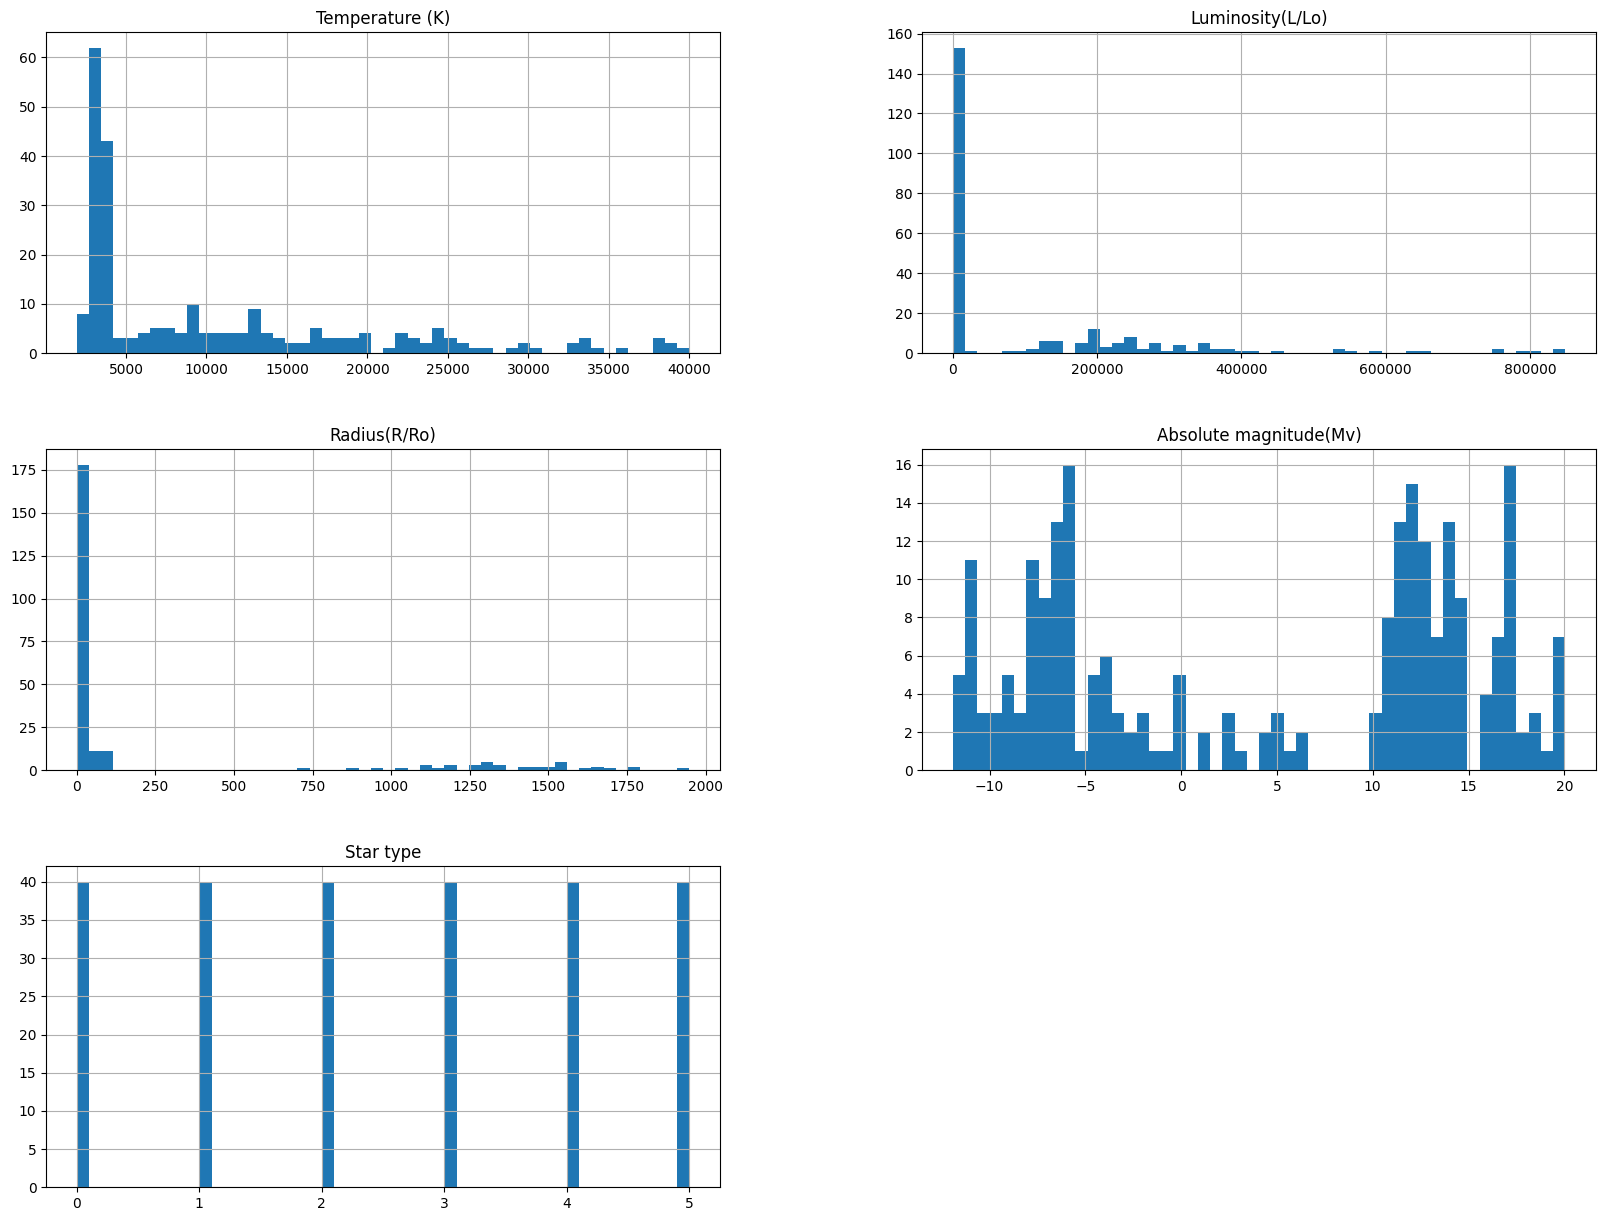

In [6]:
import matplotlib.pyplot as plt
star_data.hist(bins=50, figsize=(20,15))
plt.show()

In [7]:
star_data["Spectral Class"].value_counts()

Spectral Class
M    111
B     46
O     40
A     19
F     17
K      6
G      1
Name: count, dtype: int64

In [8]:
star_data["Star color"].value_counts()

Star color
Red                   112
Blue                   55
Blue-white             26
Blue White             10
yellow-white            8
White                   7
Blue white              3
Yellowish White         3
white                   3
Whitish                 2
Orange                  2
yellowish               2
Pale yellow orange      1
White-Yellow            1
Blue                    1
Yellowish               1
Orange-Red              1
Blue white              1
Blue-White              1
Name: count, dtype: int64

**Class Title Alteration:**
  Change all class titles to lower case text for consistency.

In [9]:
## idea from https://www.kaggle.com/code/eynardm/startypeprediction-100-star-data#Preprocessing
def fix_spelling_star_color(color):
    color = color.lower()
    if "yellow" in color and "white" in color:
        return "white yellow"
    else: 
        color = color.strip()
        color = color.replace("-", " ")
        return color

In [10]:
star_data["Star color"] = star_data["Star color"].apply(fix_spelling_star_color)

In [11]:
star_data["Star color"].value_counts()

Star color
red                   112
blue                   56
blue white             41
white yellow           12
white                  10
yellowish               3
whitish                 2
orange                  2
pale yellow orange      1
orange red              1
Name: count, dtype: int64

## Split the Data into Training and Test Set

Divide the data into a training and test set for model development and evaluation. The test set will be used exclusively for evaluation to ensure robust assessment. A "stratify feature" is generated for the train/test seperation. The instances that only appear once in the dataset (outliers) filtered to remove noise in the data.

In [12]:
star_data["stratify_feature"] = star_data[["Star color", "Spectral Class"]].apply(tuple, axis=1)

In [13]:
star_data["stratify_feature"].value_counts()

stratify_feature
(red, M)                   110
(blue, O)                   40
(blue white, B)             29
(blue, B)                   16
(white yellow, F)           12
(blue white, A)             12
(white, A)                   6
(white, F)                   4
(yellowish, K)               3
(red, G)                     1
(red, K)                     1
(orange red, K)              1
(whitish, B)                 1
(orange, M)                  1
(whitish, A)                 1
(pale yellow orange, F)      1
(orange, K)                  1
Name: count, dtype: int64

In [14]:
star_data = star_data[star_data["stratify_feature"].map(star_data["stratify_feature"].value_counts()) > 1]
star_data["stratify_feature"].value_counts()

stratify_feature
(red, M)             110
(blue, O)             40
(blue white, B)       29
(blue, B)             16
(white yellow, F)     12
(blue white, A)       12
(white, A)             6
(white, F)             4
(yellowish, K)         3
Name: count, dtype: int64

In [15]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(
    star_data, test_size=0.2, stratify=star_data["stratify_feature"], random_state=42)
train_set = train_set.drop("stratify_feature", axis=1)
test_set = test_set.drop("stratify_feature", axis=1)

In [16]:
stars = train_set.copy()

## Create Hertzsprung-Russell Diagram of Training Set
The Hertszprung-Russell Diagram is a well-known astronomical diagram used to display the relationship among spectral classes of stars with regards to their log Luminosity and Temperature. By creating this diagram with our data, we are able to both visualize the shape of our data as well as ensure that the data instances are consistent with realistic stellar attribtutes. 

<function matplotlib.pyplot.show(close=None, block=None)>

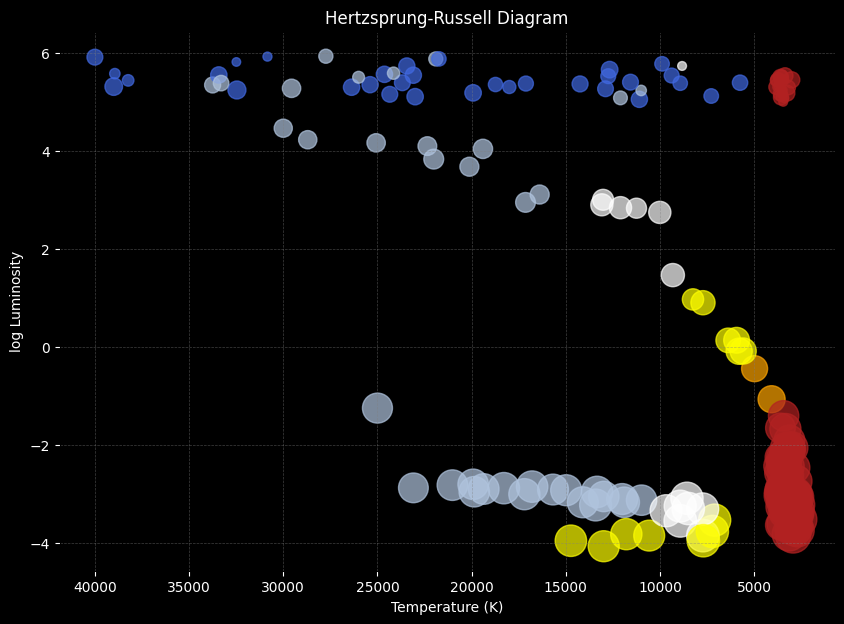

In [17]:
def spectral_class_to_color(spectral_class):
    if spectral_class == "M":
        return "firebrick"
    if spectral_class == "O":
        return "royalblue"
    if spectral_class == "B":
        return "lightsteelblue"
    if spectral_class == "F":
        return "yellow"
    if spectral_class == "A":
        return "white"
    if spectral_class == "G":
        return "gold"
    if spectral_class == "K":
        return "orange"


stars["log_Luminosity"] = np.log10(stars["Luminosity(L/Lo)"])
stars["color"] = stars["Spectral Class"].apply(spectral_class_to_color)

fig, ax = plt.subplots(figsize = (10,7))

scatter = ax.scatter(
    stars["Temperature (K)"],
    stars["log_Luminosity"],
    c = stars["color"],
    s = (stars["Absolute magnitude(Mv)"] - stars["Absolute magnitude(Mv)"].min() + 1) * 20,
    alpha = 0.7
)

ax.invert_xaxis()

ax.set_title("Hertzsprung-Russell Diagram", color="white")
ax.set_xlabel("Temperature (K)", color="white")
ax.set_ylabel("log Luminosity", color="white")

ax.set_facecolor("black")
fig.patch.set_facecolor("black")

ax.grid(color = "gray", linestyle = "--", linewidth = 0.5, alpha = 0.5)
ax.tick_params(colors="white")

plt.show


## Look at Feature Correlations with Star Type

By investigating all the correlations of features with a plot array, we can easily visualize any potential correlations in attributes that are worth taking advantage of later on in our model.

In [18]:
stars_for_corr = train_set.copy()

In [19]:
corr_matrix = stars_for_corr.corr(numeric_only = True)

In [20]:
corr_matrix["Star type"].sort_values(ascending=False)

Star type                 1.000000
Luminosity(L/Lo)          0.678583
Radius(R/Ro)              0.639383
Temperature (K)           0.479069
Absolute magnitude(Mv)   -0.955026
Name: Star type, dtype: float64

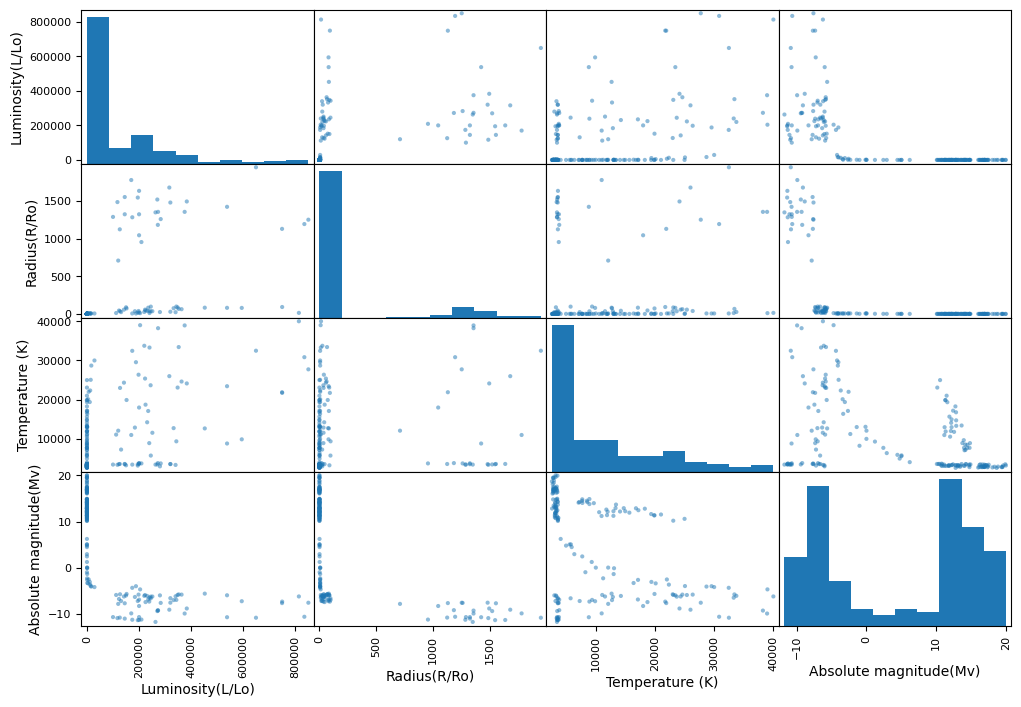

In [21]:
from pandas.plotting import scatter_matrix

attributes = ["Luminosity(L/Lo)", "Radius(R/Ro)", "Temperature (K)", "Absolute magnitude(Mv)"]
scatter_matrix(stars_for_corr[attributes], figsize=(12,8))
plt.show()

Check if log of luminosity produces a bettern correlation with star type. We can see that there is a high correlation (0.9)

In [22]:
stars_for_corr["log Luminosity"] = np.log10(stars["Luminosity(L/Lo)"])

In [23]:
corr_matrix = stars_for_corr.corr(numeric_only=True)
corr_matrix["Star type"].sort_values(ascending=False)

Star type                 1.000000
log Luminosity            0.903322
Luminosity(L/Lo)          0.678583
Radius(R/Ro)              0.639383
Temperature (K)           0.479069
Absolute magnitude(Mv)   -0.955026
Name: Star type, dtype: float64

In [24]:
stars = train_set.drop("Star type", axis=1)
stars_labels = train_set["Star type"].copy()

## Checking Distributions of Features

Check to see if approximately even distribution of star types in the training set

In [25]:
stars_labels.value_counts()

Star type
1    35
4    34
2    32
0    31
5    27
3    26
Name: count, dtype: int64

## One Hot Encoding
Due to the relatively small number of possible classes, we apply a One Hot Encoding feature alteration to our data so that we can better use Star Color and Spectral Class (categorical variables) in our model.  

In [26]:
stars_cat = stars[["Star color", "Spectral Class"]]
encoder = OneHotEncoder(sparse_output=False)
encoded_data = encoder.fit_transform(stars_cat)
encoded_stars = pd.DataFrame(encoded_data, columns = encoder.get_feature_names_out(["Star color", "Spectral Class"]))
encoded_stars.index = stars.drop(["Star color", "Spectral Class"], axis=1).index
stars_encoded = pd.concat([stars.drop(["Star color", "Spectral Class"], axis=1), encoded_stars], axis=1)


## Feature Engineering
We also add a feature for log Luminosity, as we observed that there seems to be a high correlation between this calculation and spectral class.

In [27]:
stars_encoded["log Luminosity"] = np.log10(stars["Luminosity(L/Lo)"])

In [28]:
stars_encoded.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star color_blue,Star color_blue white,Star color_red,Star color_white,Star color_white yellow,Star color_yellowish,Spectral Class_A,Spectral Class_B,Spectral Class_F,Spectral Class_K,Spectral Class_M,Spectral Class_O,log Luminosity
97,7720,7.92000,1.3400,2.44,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.898725
225,18734,224780.00000,46.0000,-7.45,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.351758
78,2621,0.00060,0.0980,12.81,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-3.221849
38,5936,1.35700,1.1060,4.46,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.132580
120,3323,0.00043,0.0912,17.16,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-3.366532


## Feature Scaling
The features are scaled to avoid skewing in the model training towards features with more dynamic or expansive ranges. This ensures that the influence features have on each other is controlled within the model. We use a robust scaler to do this.

In [29]:
scaler = RobustScaler(quantile_range = (25.0, 75.0))
scaled_data = scaler.fit_transform(stars_encoded)
stars_scaled = pd.DataFrame(scaled_data, columns=stars_encoded.columns)


In [30]:
stars_scaled.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star color_blue,Star color_blue white,Star color_red,Star color_white,Star color_white yellow,Star color_yellowish,Spectral Class_A,Spectral Class_B,Spectral Class_F,Spectral Class_K,Spectral Class_M,Spectral Class_O,log Luminosity
0,0.155390,4.208085e-05,0.024206,-0.410803,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.354003
1,1.046779,1.195638e+00,1.268210,-0.900892,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.887604
2,-0.257284,-4.361702e-08,-0.010390,0.103072,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.139760
3,0.011007,7.171277e-06,0.017688,-0.310704,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.262197
4,-0.200469,-4.452128e-08,-0.010579,0.318632,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.157097


## Training Models

Decision Tree Classifier

In [31]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'max_depth': [5,6,7,8,9,10],
     'min_samples_split': [10,20,30,40],
     'max_features': [8, 10, 12, 14, 16]
    }
]

In [32]:
tree_classifier = DecisionTreeClassifier()
grid_search = GridSearchCV(tree_classifier, param_grid, cv=5, return_train_score=True)
grid_search.fit(stars_scaled, stars_labels)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid=[{'max_depth': [5, 6, 7, 8, 9, 10],
                          'max_features': [8, 10, 12, 14, 16],
                          'min_samples_split': [10, 20, 30, 40]}],
             return_train_score=True)

In [33]:
best_params = grid_search.best_params_
print("Best Parameters:", best_params)
best_tree = grid_search.best_estimator_

Best Parameters: {'max_depth': 5, 'max_features': 10, 'min_samples_split': 10}


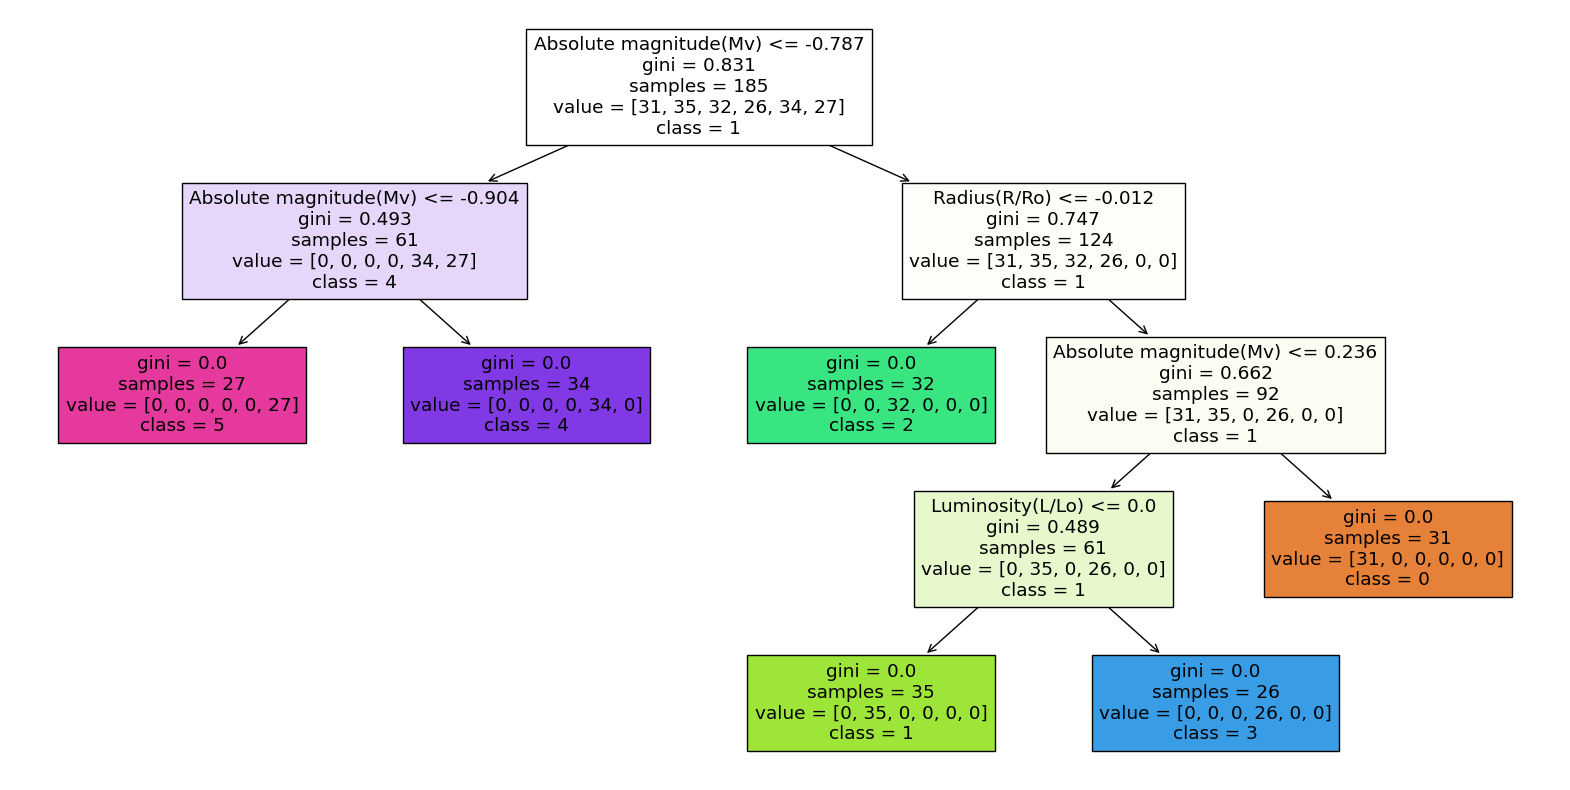

In [34]:
from sklearn.tree import plot_tree

class_names = grid_search.classes_

plt.figure(figsize=(20, 10))  # Adjust size as needed
plot_tree(best_tree,
          feature_names=["Temperature (K)", 
                         "Luminosity(L/Lo)", 
                         "Radius(R/Ro)", 
                         "Absolute magnitude(Mv)",
                         "Star color_blue",
                         "Star color_blue white",
                         "Star color_orange",
                         "Star color_pale yellow orange",
                         "Star color_red",
                         "Star color_white",
                         "Star color_white yellow",
                         "Star color_whitish",
                         "Star color_yellowish",
                         "Spectral Class_A",
                         "Spectral Class_B",
                         "Spectral Class_F",
                         "Spectral Class_G",
                         "Spectral Class_K",
                         "Spectral Class_M",
                         "Spectral Class_O",
                         "log Luminosity"],
          class_names=class_names.astype(str).tolist(),
          filled=True)
plt.show()

In [35]:
from sklearn.ensemble import RandomForestClassifier

random_classifier = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)

In [36]:
random_classifier.fit(stars_scaled, stars_labels)

RandomForestClassifier(max_leaf_nodes=16, n_estimators=500, n_jobs=-1,
                       random_state=42)

In [37]:
for score, name in zip(random_classifier.feature_importances_, stars_scaled.columns):
    print(round(score, 2), name)

0.08 Temperature (K)
0.11 Luminosity(L/Lo)
0.26 Radius(R/Ro)
0.26 Absolute magnitude(Mv)
0.02 Star color_blue
0.01 Star color_blue white
0.05 Star color_red
0.0 Star color_white
0.0 Star color_white yellow
0.0 Star color_yellowish
0.0 Spectral Class_A
0.01 Spectral Class_B
0.0 Spectral Class_F
0.0 Spectral Class_K
0.04 Spectral Class_M
0.02 Spectral Class_O
0.13 log Luminosity


## Predictions

In [38]:
stars_test = test_set.drop("Star type", axis=1)
stars_test_labels = test_set["Star type"].copy()

In [39]:
stars_test.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star color,Spectral Class
134,3542,0.0009,0.620,14.230,red,M
91,4526,0.1530,0.865,6.506,yellowish,K
99,36108,198000.0000,10.200,-4.400,blue,O
151,8945,38.0000,2.487,0.120,blue white,A
169,9373,424520.0000,24.000,-5.990,blue,O


In [40]:
# one hot encoding
stars_cat_test = stars_test[["Star color", "Spectral Class"]]
encoder_test = OneHotEncoder(sparse_output=False)
encoded_data_test = encoder_test.fit_transform(stars_cat_test)
encoded_stars_test = pd.DataFrame(encoded_data_test, columns = encoder_test.get_feature_names_out(["Star color", "Spectral Class"]))
encoded_stars_test.index = stars_test.drop(["Star color", "Spectral Class"], axis=1).index
stars_encoded_test = pd.concat([stars_test.drop(["Star color", "Spectral Class"], axis=1), encoded_stars_test], axis=1)


# feature engineering
stars_encoded_test["log Luminosity"] = np.log10(stars_test["Luminosity(L/Lo)"])

# feature scaling
scaler = RobustScaler(quantile_range = (25.0, 75.0))
scaled_data_test = scaler.fit_transform(stars_encoded_test)
stars_scaled_test = pd.DataFrame(scaled_data_test, columns=stars_encoded_test.columns)


In [41]:
stars_scaled_test.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star color_blue,Star color_blue white,Star color_red,Star color_white,Star color_white yellow,Star color_yellowish,Spectral Class_A,Spectral Class_B,Spectral Class_F,Spectral Class_K,Spectral Class_M,Spectral Class_O,log Luminosity
0,-0.141975,-0.000007,-0.010895,0.620245,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.382675
1,-0.062508,-0.000006,-0.005556,0.214934,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.116036
2,2.488027,0.994468,0.197847,-0.357349,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.614621
3,0.294367,0.000184,0.029786,-0.120166,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.170286
4,0.328932,2.132188,0.498540,-0.440783,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.654218


In [42]:
from sklearn.metrics import accuracy_score

prediction_dt = best_tree.predict(stars_scaled_test)

accuracy = accuracy_score(stars_test_labels, prediction_dt)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 31.91%


In [43]:
prediction_rf = random_classifier.predict(stars_scaled_test)

accuracy = accuracy_score(stars_test_labels, prediction_rf)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 76.60%
